In [1]:

import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
#Read the data into a pandas data frame 
df = pd.read_parquet("de_train.parquet")
df_copy = df

In [3]:
#normalizes data between -1 and 1
#returns normalized data and the factors used to normalzie 
def normalize(df):
    min = df.min()
    max=df.max()
    df_normalized = (df - min) / (max-min)
    return df_normalized, min.reset_index(drop=True), max.reset_index(drop=True)


#unnormalize
def unnormalize(normalized_df, min, max):
    return min + normalized_df*(max-min)

In [4]:
############################DATA PREP###############################



####One hot incodes inputs####

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)
cell_mapping = encoder.categories_[0]

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)
compound_mapping = encoder.categories_[0]

#Puts together inputs
inputs = np.hstack((hot_cells, hot_compounds))
inputs_df = pd.DataFrame(data = inputs)


####Normalizes Outputs####

outputs = df.loc[:, 'A1BG':'ZZEF1']
outputs_norm_df, norm_min, norm_max = normalize(outputs)


####Puts Inputs and Outputs Together####
prepped_df = pd.concat([inputs_df, outputs_norm_df], axis=1)



In [28]:
from torch.utils.data import DataLoader, Dataset

#Break into training and validation and split inputs from outputs
val, train = train_test_split(prepped_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:151]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:151]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

#Transforms data frames into tensors
trainIn_t = torch.tensor(trainIn_df.values).float()
trainOut_t = torch.tensor(trainOut_df.values).float()
valIn_t = torch.tensor(valIn_df.values).float()
valOut_t = torch.tensor(valOut_df.values).float()




In [26]:

import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(152, 512)  # First hidden layer
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(512, 1024) # Second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(1024, 512) # Third hidden layer
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.3)

        self.layer4 = nn.Linear(512, 256) # Fourth hidden layer
        self.batch_norm4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(256, 18211) # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.batch_norm1(self.layer1(x)))
        x = self.dropout1(x)

        x = F.relu(self.batch_norm2(self.layer2(x)))
        x = self.dropout2(x)

        x = F.relu(self.batch_norm3(self.layer3(x)))
        x = self.dropout3(x)

        x = F.relu(self.batch_norm4(self.layer4(x)))
        x = self.dropout4(x)

        x = self.output_layer(x)
        return x


In [27]:

import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def train_model(model, trainIn_t, trainOut_t, valIn_t, valOut_t, batch_size, num_epochs):
    criterion = nn.BCEWithLogitsLoss()  # Adjust according to your needs
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3, verbose=True)

    num_samples = trainIn_t.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0

        # Shuffle the data at the beginning of each epoch
        permutation = torch.randperm(num_samples)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            indices = permutation[start_idx:end_idx]

            batch_trainIn = trainIn_t[indices]
            batch_trainOut = trainOut_t[indices]

            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_trainIn)

            # Compute loss
            loss = criterion(outputs, batch_trainOut)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(indices)

        epoch_loss /= num_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_output_predictions = model(valIn_t)
            val_loss = criterion(val_output_predictions, valOut_t)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return model

# Usage example:
# model = YourModel()  # Replace with your actual model
# trained_model = train_model(model, trainIn_t, trainOut_t, valIn_t, valOut_t, batch_size=32, num_epochs=25)



In [20]:
type(trainIn_t)

torch.Tensor

In [21]:
model = CustomNetwork()
trained_model = train_model(model, trainIn_t, trainOut_t, valIn_t, valOut_t, batch_size=32, num_epochs=25)

Epoch 1/25, Training Loss: 0.6106, Validation Loss: 0.5982
Epoch 2/25, Training Loss: 0.5430, Validation Loss: 0.5335
Epoch 3/25, Training Loss: 0.5370, Validation Loss: 0.5347
Epoch 4/25, Training Loss: 0.5328, Validation Loss: 0.5309
Epoch 5/25, Training Loss: 0.5289, Validation Loss: 0.5276
Epoch 6/25, Training Loss: 0.5273, Validation Loss: 0.5279
Epoch 7/25, Training Loss: 0.5260, Validation Loss: 0.5289
Epoch 8/25, Training Loss: 0.5259, Validation Loss: 0.5294
Epoch 9/25, Training Loss: 0.5251, Validation Loss: 0.5275
Epoch 10/25, Training Loss: 0.5245, Validation Loss: 0.5276
Epoch 11/25, Training Loss: 0.5241, Validation Loss: 0.5280
Epoch 12/25, Training Loss: 0.5237, Validation Loss: 0.5275
Epoch 13/25, Training Loss: 0.5235, Validation Loss: 0.5275
Epoch 14/25, Training Loss: 0.5231, Validation Loss: 0.5277
Epoch 00015: reducing learning rate of group 0 to 3.0000e-04.
Epoch 15/25, Training Loss: 0.5227, Validation Loss: 0.5278
Epoch 16/25, Training Loss: 0.5223, Validation 

Epoch 0, Training Loss: 0.6041449629305226, Validation Loss: 0.5427264886793524
Epoch 1, Training Loss: 0.5280335664218476, Validation Loss: 0.5282827766061685
Epoch 2, Training Loss: 0.5242546831051645, Validation Loss: 0.5275190599640878
Epoch 3, Training Loss: 0.5232634992738846, Validation Loss: 0.5274167516867438
Epoch 4, Training Loss: 0.5226053236334984, Validation Loss: 0.527329248870538
Epoch 5, Training Loss: 0.5221476352814999, Validation Loss: 0.527240280101558
Epoch 6, Training Loss: 0.5218100449916384, Validation Loss: 0.5271708795021524
Epoch 7, Training Loss: 0.5215394598120416, Validation Loss: 0.5271451397455478
Epoch 8, Training Loss: 0.5213078861957883, Validation Loss: 0.5271483915067472
Epoch 9, Training Loss: 0.5210953703252927, Validation Loss: 0.5271655124207328
Epoch 10, Training Loss: 0.5210365603800384, Validation Loss: 0.5269221140160584
Epoch 11, Training Loss: 0.5208196153000803, Validation Loss: 0.5268880699482704
Epoch 12, Training Loss: 0.5207867470370

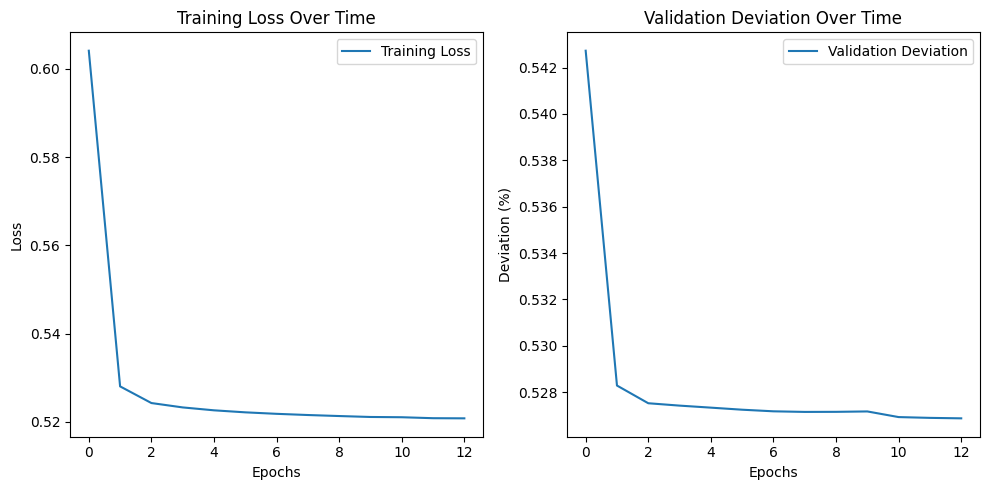

In [10]:

# Call your train(epochs, batch size, layers) function
train_losses, test_losses, model = train(13, 20, [152,200,500,18211])

# Now plot the loss over epochs
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()


# Plotting the deviation over epochs
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Validation Deviation')
plt.xlabel('Epochs')
plt.ylabel('Deviation (%)')
plt.title('Validation Deviation Over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def hot_encode(cell,compound):
    cell_vec = np.zeros(cell_mapping.size)
    cell_dict = {value: index for index, value in enumerate(cell_mapping)}

    compound_vec = np.zeros(compound_mapping.size)
    compound_dict = {value: index for index, value in enumerate(compound_mapping)}


    cell_vec[cell_dict[cell]]=1
    compound_vec[compound_dict[compound]]=1
    vector = np.concatenate((cell_vec, compound_vec), axis = 0)
    tensor = torch.from_numpy(vector)
    return tensor


In [ ]:
model(hot_encode("NK cells", "Clotrimazole"))

tensor([0.1321, 0.2412, 0.4950,  ..., 0.4223, 0.4664, 0.5452],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [ ]:
def get_expression(cell_type, compound_name):
    tensor = model(hot_encode(cell_type,compound_name))
    np_array = tensor.detach().numpy()
    df = pd.DataFrame(np_array)
    return unnormalize(df[0],norm_min,norm_max)


df = get_expression("NK cells", "Clotrimazole")
print(df)




0        0.089716
1        0.392768
2       -0.776956
3       -0.502081
4        0.056250
           ...   
18206    0.132327
18207    0.040884
18208    0.039621
18209   -0.185311
18210   -0.264756
Length: 18211, dtype: float64


In [ ]:
# Read the sample submission and test set ID map
sample_submission = pd.read_csv("sample_submission.csv")
testDf = pd.read_csv("id_map.csv")

# Initialize an empty list to collect the predicted values
predicted_values = []

# Loop through the test set to get the predicted values
for idx, row in testDf.iterrows():
    cell_type = row['cell_type']
    sm_name = row['sm_name']
    
    # Call your get_expression method here
    expression_values = get_expression(cell_type, sm_name)
    
    # Append the values to the list
    predicted_values.append(expression_values)

# Convert the list of predicted values to a numpy array
predicted_values_array = np.array(predicted_values)

# Replace the values in the sample submission DataFrame
sample_submission.iloc[:, 1:] = predicted_values_array

# Save the DataFrame to a new CSV file
sample_submission.to_csv("my_submission.csv", index=False)



FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [ ]:
row_one = copy_df.iloc[0][5:]
row_one_output = get_expression(copy_df.iloc[0][0], copy_df.iloc[0][1])

for i in range( len(row_one)):
    print(f"{row_one[i]}     {row_one_output[i]}")